# Adversarial Attacks for Legal NER

Targeted adversarial evaluation for the fine-tuned Portuguese BERT NER model (LeNER-Br). The notebook reuses the saved checkpoint, applies sliding-window inference to avoid truncation, and tests targeted perturbations aligned with prior robustness and interpretability findings.


In [51]:
import os
import random
import string
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from seqeval.metrics import precision_score, recall_score, f1_score
from seqeval.metrics.sequence_labeling import get_entities
from transformers import AutoModelForTokenClassification, AutoTokenizer

plt.rcParams['figure.figsize'] = (8, 4)

SEED = 42
EVAL_SIZE = 200
MAX_LENGTH = 256
STRIDE = 64

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')



Using device: cuda


In [52]:
# Load dataset
dataset_id = 'peluz/lener_br'
hf_token = os.getenv('HF_TOKEN')
lener = load_dataset(dataset_id, token=hf_token)

ner_feature = lener['train'].features['ner_tags']
label_list = ner_feature.feature.names
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

val_subset = lener['validation'].select(range(EVAL_SIZE))
print(val_subset)
print('Labels:', label_list)



c:\Users\diogo\Repositorios\ner_smalllm_project\.venv\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for peluz/lener_br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/peluz/lener_br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 200
})
Labels: ['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA']


In [53]:
# Load fine-tuned model and tokenizer
model_dir = r"C:\Users\diogo\Repositorios\ner_smalllm_project\notebooks\models\lenerbr_bert_base"

model = AutoModelForTokenClassification.from_pretrained(model_dir)
model.config.id2label = id2label
model.config.label2id = label2id
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_dir)
num_labels = model.config.num_labels

## Helper utilities


In [54]:
def get_gold_labels(example) -> List[str]:
    return [label_list[t] for t in example['ner_tags']]


def get_spans(labels: List[str]) -> List[Tuple[str, int, int]]:
    """Return spans as (type, start, end) inclusive for BIO labels.
    Robust to inconsistent BIO (e.g., I-X after B-Y).
    """
    spans: List[Tuple[str, int, int]] = []
    ent_type = None
    start = None

    for i, tag in enumerate(labels):
        if tag.startswith("B-"):
            # close previous
            if ent_type is not None:
                spans.append((ent_type, start, i - 1))
            ent_type = tag[2:]
            start = i

        elif tag.startswith("I-"):
            cur_type = tag[2:]
            if ent_type is None:
                # start a new span if I- appears without a preceding B-
                ent_type = cur_type
                start = i
            elif cur_type != ent_type:
                # BIO inconsistency: close previous and start a new span
                spans.append((ent_type, start, i - 1))
                ent_type = cur_type
                start = i

        else:  # "O"
            if ent_type is not None:
                spans.append((ent_type, start, i - 1))
                ent_type = None
                start = None

    if ent_type is not None:
        spans.append((ent_type, start, len(labels) - 1))

    return spans

## Sliding-window prediction (no truncation mismatches)
Uses overlapping windows with stride to cover long sequences; logits for shared words are summed before argmax.


In [55]:
def predict_word_logits(tokens: List[str]) -> np.ndarray:
    """Aggregate logits over sliding windows. Returns shape (n_words, num_labels)."""
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_overflowing_tokens=True,
        stride=STRIDE,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None,
        padding=False,
    )

    n_words = len(tokens)
    agg = np.zeros((n_words, num_labels), dtype=np.float32)
    counts = np.zeros(n_words, dtype=np.float32)

    for i in range(len(encoding['input_ids'])):
        input_ids = torch.tensor(encoding['input_ids'][i]).unsqueeze(0).to(device)
        attention_mask = torch.tensor(encoding['attention_mask'][i]).unsqueeze(0).to(device)
        word_ids = encoding.word_ids(i)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(0).cpu().numpy()

        for pos, wid in enumerate(word_ids):
            if wid is None:
                continue
            agg[wid] += logits[pos]
            counts[wid] += 1

    if (counts == 0).any():
        missing = np.where(counts == 0)[0].tolist()
        raise ValueError(f'Missing logits for word indices: {missing}')

    agg /= counts[:, None]
    return agg


def predict_word_labels(tokens: List[str]) -> List[str]:
    logits = predict_word_logits(tokens)
    pred_ids = logits.argmax(axis=1)
    return [label_list[i] for i in pred_ids]


# Quick sanity check on a long example
idx_long = max(range(len(val_subset)), key=lambda i: len(val_subset[i]["tokens"]))
long_example = val_subset[idx_long]["tokens"]

logits_test = predict_word_logits(long_example)
print("Sanity check lengths:", len(long_example), logits_test.shape)

Sanity check lengths: 211 (211, 13)


## Attacks (substitution-only to preserve alignment)


In [56]:
DISTRACTORS = ['xxx', 'lorem', 'teste', 'ruido']
SYN_MAP = {
    'TRIBUNAL': 'CORTE',
    'MINISTRO': 'AUTORIDADE',
    'LEI': 'NORMA',
    'ACÓRDÃO': 'DECISAO',
    'JUIZ': 'MAGISTRADO',
}


def mutate_token(token: str) -> str:
    if len(token) <= 1:
        return token
    ops = ['swap', 'replace', 'delete']
    op = random.choice(ops)
    if op == 'swap' and len(token) >= 3:
        i = random.randint(1, len(token) - 2)
        chars = list(token)
        chars[i], chars[i + 1] = chars[i + 1], chars[i]
        return ''.join(chars)
    if op == 'delete' and len(token) > 1:
        i = random.randint(0, len(token) - 1)
        mutated = token[:i] + token[i + 1 :]
        return mutated or token
    i = random.randint(0, len(token) - 1)
    return token[:i] + random.choice(string.ascii_lowercase) + token[i + 1 :]


def attack_char_typo(tokens: List[str], gold_labels: List[str], p: float = 0.5) -> List[str]:
    attacked = []
    for tok, lab in zip(tokens, gold_labels):
        if lab != 'O' and random.random() < p:
            attacked.append(mutate_token(tok))
        else:
            attacked.append(tok)
    return attacked


def attack_boundary(tokens: List[str], gold_labels: List[str]) -> List[str]:
    """Replace punctuation immediately before/after entity spans with placeholders (length preserved)."""
    spans = get_spans(gold_labels)
    boundary_idxs = set()

    for _, s, e in spans:
        if s - 1 >= 0:
            boundary_idxs.add(s - 1)
        if e + 1 < len(tokens):
            boundary_idxs.add(e + 1)

    attacked = list(tokens)
    for i in boundary_idxs:
        if attacked[i] in {"(", ")", ",", "."}:
            attacked[i] = "__"  # neutral placeholder, length preserved

    return attacked


def attack_context_distractors(tokens: List[str], gold_labels: List[str]) -> List[str]:
    """Replace tokens immediately before/after spans with distractors (length preserved)."""
    spans = get_spans(gold_labels)
    attacked = list(tokens)
    for _, s, e in spans:
        if s - 1 >= 0:
            attacked[s - 1] = random.choice(DISTRACTORS)
        if e + 1 < len(tokens):
            attacked[e + 1] = random.choice(DISTRACTORS)
    return attacked


def attack_synonym(tokens: List[str], gold_labels: List[str]) -> List[str]:
    attacked = []
    for tok, lab in zip(tokens, gold_labels):
        key = tok.upper()
        if lab != 'O' and key in SYN_MAP:
            repl = SYN_MAP[key]
            attacked.append(repl.title() if tok.istitle() else repl.lower())
        else:
            attacked.append(tok)
    return attacked


ATTACKS = {
    'baseline': None,
    'char_typo': attack_char_typo,
    'boundary': attack_boundary,
    'context_distractors': attack_context_distractors,
    'synonym': attack_synonym,
}

## Evaluation helpers
Includes per-type F1, flip rate, span break rate, and confidence drop.


In [57]:
def compute_per_type_f1(
    golds: List[List[str]], preds: List[List[str]]
) -> Dict[str, float]:
    """
    Per-entity-type F1 using seqeval entity extraction.
    Entity types are: ORGANIZACAO, PESSOA, TEMPO, LOCAL, LEGISLACAO, JURISPRUDENCIA.
    """
    # Build the set of entity types from the label list (ignore O, B-, I- prefixes)
    entity_types = sorted({lbl.split("-", 1)[1] for lbl in label_list if lbl != "O"})
    counts = {t: {"tp": 0, "fp": 0, "fn": 0} for t in entity_types}

    for g_seq, p_seq in zip(golds, preds):
        g_ents = set(get_entities(g_seq))  # returns tuples like (TYPE, start, end)
        p_ents = set(get_entities(p_seq))

        for ent in g_ents & p_ents:
            counts[ent[0]]["tp"] += 1
        for ent in p_ents - g_ents:
            counts[ent[0]]["fp"] += 1
        for ent in g_ents - p_ents:
            counts[ent[0]]["fn"] += 1

    f1s: Dict[str, float] = {}
    for t, c in counts.items():
        tp, fp, fn = c["tp"], c["fp"], c["fn"]
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) else 0.0
        f1s[f"f1_{t}"] = f1

    return f1s


def compute_entity_flip_rate(golds, base_preds, attack_preds) -> float:
    total = 0
    flips = 0
    for g_seq, b_seq, a_seq in zip(golds, base_preds, attack_preds):
        for g, b, a in zip(g_seq, b_seq, a_seq):
            if g == 'O':
                continue
            total += 1
            if b == g and a != g:
                flips += 1
    return flips / total if total else 0.0


def compute_span_break_rate(golds, preds) -> float:
    broken = 0
    total = 0
    for g_seq, p_seq in zip(golds, preds):
        gold_spans = set(get_spans(g_seq))
        pred_spans = set(get_spans(p_seq))
        total += len(gold_spans)
        for span in gold_spans:
            if span not in pred_spans:
                broken += 1
    return broken / total if total else 0.0


def compute_confidence_drop(golds, base_logits, attack_logits) -> float:
    deltas = []
    for g_seq, b_log, a_log in zip(golds, base_logits, attack_logits):
        for g, b_row, a_row in zip(g_seq, b_log, a_log):
            if g == 'O':
                continue
            deltas.append(b_row.max() - a_row.max())
    return float(np.mean(deltas)) if deltas else 0.0


def run_predictions(dataset_split, attack_fn: Callable = None):
    golds, preds, logits_list = [], [], []
    original_tokens, attacked_tokens = [], []
    for ex in dataset_split:
        tokens = ex['tokens']
        gold = get_gold_labels(ex)
        attacked = tokens if attack_fn is None else attack_fn(tokens, gold)
        logits = predict_word_logits(attacked)
        pred_ids = logits.argmax(axis=1)
        pred_labels = [label_list[i] for i in pred_ids]

        assert len(pred_labels) == len(gold), f'Length mismatch: pred={len(pred_labels)} gold={len(gold)}'

        golds.append(gold)
        preds.append(pred_labels)
        logits_list.append(logits)
        original_tokens.append(tokens)
        attacked_tokens.append(attacked)
    return original_tokens, attacked_tokens, golds, preds, logits_list


def evaluate_attack(name: str, golds, preds, base_preds, base_logits=None, attack_logits=None) -> Dict[str, float]:
    metrics = {
        'attack': name,
        'precision': precision_score(golds, preds),
        'recall': recall_score(golds, preds),
        'f1': f1_score(golds, preds),
        'entity_flip_rate': compute_entity_flip_rate(golds, base_preds, preds),
        'span_break_rate': compute_span_break_rate(golds, preds),
    }
    if base_logits is not None and attack_logits is not None:
        metrics['confidence_drop'] = compute_confidence_drop(golds, base_logits, attack_logits)
    metrics.update(compute_per_type_f1(golds, preds))
    return metrics

## Run baseline and attacks


In [58]:
# Baseline
base_orig, base_tokens, golds, base_preds, base_logits = run_predictions(val_subset)

results = []
attack_runs = {'baseline': {'tokens': base_tokens, 'preds': base_preds, 'logits': base_logits}}
results.append(evaluate_attack('baseline', golds, base_preds, base_preds, base_logits, base_logits))

for name, fn in ATTACKS.items():
    if name == 'baseline':
        continue
    attacked_orig, attacked_tokens, golds_tmp, preds_tmp, logits_tmp = run_predictions(val_subset, attack_fn=fn)
    attack_runs[name] = {'tokens': attacked_tokens, 'preds': preds_tmp, 'logits': logits_tmp}
    results.append(evaluate_attack(name, golds_tmp, preds_tmp, base_preds, base_logits, logits_tmp))

results_df = pd.DataFrame(results).set_index('attack')
results_df



,precision,recall,f1,entity_flip_rate,span_break_rate,confidence_drop,f1_JURISPRUDENCIA,f1_LEGISLACAO,f1_LOCAL,f1_ORGANIZACAO,f1_PESSOA,f1_TEMPO
attack,,,,,,,,,,,,
baseline,0.833333,0.893939,0.862573,0.000000,0.106061,0.000000,0.781250,0.949367,0.560000,0.824034,0.894118,1.000000
char_typo,0.705357,0.718182,0.711712,0.151232,0.281818,0.379336,0.500000,0.797101,0.250000,0.694064,0.844444,0.945055
boundary,0.827298,0.900000,0.862119,0.002549,0.100000,0.038783,0.757576,0.974684,0.509804,0.825532,0.894118,1.000000
context_distractors,0.765677,0.703030,0.733017,0.127443,0.296970,0.057941,0.509091,0.942675,0.488889,0.595122,0.776471,0.906977
synonym,0.829545,0.884848,0.856305,0.005947,0.115152,0.034072,0.781250,0.923077,0.560000,0.824034,0.894118,1.000000


## Plot overall F1 drop


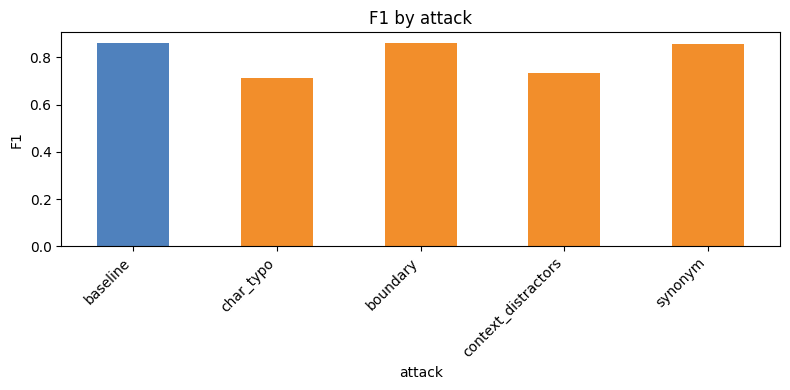

In [ ]:
import os
os.makedirs('reports/figures', exist_ok=True)

baseline_f1 = results_df.loc['baseline', 'f1']
ax = results_df['f1'].plot(kind='bar', color=['#4f81bd' if i=='baseline' else '#f28e2b' for i in results_df.index])
ax.set_ylabel('F1')
ax.set_title('F1 by attack')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Qualitative examples
Compact before/after views for selected indices.


In [60]:
SAMPLE_IDXS = [0, 2, 5]


def format_tokens(tokens: List[str], labels: List[str]) -> str:
    return ' '.join(f"{t}/{l}" for t, l in zip(tokens, labels))


def show_examples(attack_name: str, sample_indices=SAMPLE_IDXS):
    print(f"=== Attack: {attack_name} ===")
    atk_tokens = attack_runs[attack_name]['tokens']
    atk_preds = attack_runs[attack_name]['preds']
    for idx in sample_indices:
        orig_tokens = base_orig[idx]
        gold = golds[idx]
        base_pred = base_preds[idx]
        attacked_tok = atk_tokens[idx]
        attacked_pred = atk_preds[idx]
        print(f"Example {idx}")
        print("Gold:     ", format_tokens(orig_tokens, gold))
        print("Baseline: ", format_tokens(orig_tokens, base_pred))
        print("Attacked: ", format_tokens(attacked_tok, attacked_pred))
        diffs = [i for i, (g, a) in enumerate(zip(gold, attacked_pred)) if i < len(attacked_pred) and g != a]
        if diffs:
            print(f"Changed positions: {diffs}")
        else:
            print("No changes on gold spans.")

for name in ATTACKS:
    if name == 'baseline':
        continue
    show_examples(name)



=== Attack: char_typo ===
Example 0
Gold:      E/O M/O E/O N/O T/O A/O Órgão/O :/O 8ª/B-ORGANIZACAO TURMA/I-ORGANIZACAO CÍVEL/I-ORGANIZACAO Classe/O :/O APELAÇÃO/O CÍVEL/O N/O ./O Processo/O :/O 20150110436469APC/B-JURISPRUDENCIA (/O 0012843-03.2015.8.07.0001/B-JURISPRUDENCIA )/O Apelante/O (/O s/O )/O :/O BRASILIA/B-ORGANIZACAO CURSOS/I-ORGANIZACAO E/I-ORGANIZACAO CONCURSOS/I-ORGANIZACAO LTDA/I-ORGANIZACAO GRANCURSOS/I-ORGANIZACAO ESCOLA/I-ORGANIZACAO PARA/I-ORGANIZACAO CONCURSOS/I-ORGANIZACAO PUBLICOS/I-ORGANIZACAO LTDA/O Apelado/O (/O s/O )/O :/O ALISSON/B-PESSOA SILVA/I-PESSOA BATISTA/I-PESSOA DE/I-PESSOA MORAES/I-PESSOA Relatora/O :/O Desembargadora/O NÍDIA/B-PESSOA CORRÊA/I-PESSOA LIMA/I-PESSOA Acórdão/B-JURISPRUDENCIA N./I-JURISPRUDENCIA :/I-JURISPRUDENCIA 1082726/I-JURISPRUDENCIA CIVIL/O E/O PROCESSUAL/O CIVIL/O ./O
Baseline:  E/O M/O E/O N/O T/O A/O Órgão/O :/O 8ª/B-ORGANIZACAO TURMA/I-ORGANIZACAO CÍVEL/I-ORGANIZACAO Classe/O :/O APELAÇÃO/O CÍVEL/O N/O ./O Processo/O :/O 20150

## Discussion
- **Typo attack (char_typo)**: corrupts entity anchors; large F1 and confidence drops align with robustness character-noise failures.
- **Boundary attack**: altering punctuation near spans breaks structural cues, echoing interpretability that punctuation acts as delimiters.
- **Context distractors**: replacing context around spans dilutes attention on anchors, similar to robustness collapse under word insertion.
- **Synonyms**: minimal drops because meaning is preserved; model still attends to anchors, consistent with robustness and interpretability.

Hardening ideas: targeted augmentation with typos/boundaries/distractors, adversarial training on anchor-corruptions, and exploring char/byte-aware tokenization to reduce surface-form brittleness.
